# Feature extraction

In the previous exercise, we learned how to select the best features from the set. Today we will learn how to transform an existing set of features into another set with different dimensionality. The topic of dimensionality reduction is one of the key concepts in data mining. It is going to be used here, just to present data on a two-dimensional graph. This very concept is also used in other tasks, such as clustering or noise reduction. We are going to discuss 3 feature extraction algorithms:

 - PCA/SVD
 - UMAP
 - LDA

Keep in mind, that there are way more feature extraction algorithms, we are using the most principled ones, the ones which are most commonly used. For example, you could imagine an Autoencoder performing exactly this task.
We are going to work on the Iris dataset from sklearn throughout the notebook. Finally, you will be asked to perform the feature extraction on the Wine dataset.


In [413]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [414]:
from sklearn.datasets import load_iris

data = load_iris()

X = data['data']
y = data['target']

Before we go any further it should be noted that feature extraction, requires the data to have meanigfully comparable features. So we **always perform feature normalization** prior to feature extraction. In this exercise we will standardize the features. Standarization is the "go to" normalization for the feature extraction. 

In [415]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

X_scaled[:5], y[:5]

Iris_df = pd.DataFrame(X_scaled, y, columns = data.feature_names)
Iris_df.describe().round(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.00,150.00,150.00,150.00
mean,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.87,-2.43,-1.57,-1.45
25%,-0.90,-0.59,-1.23,-1.18
50%,-0.05,-0.13,0.34,0.13
75%,0.67,0.56,0.76,0.79
max,2.49,3.09,1.79,1.71


## Principal Component Analysis / Singular Value Decomposition

PCA and SVD are closely related. In fact, the PCA is most commonly implemented with the underlying SVD implementation. I suggest [this](https://arxiv.org/pdf/1404.1100.pdf) reading if you want to go into details of how SVD works and its relation to PCA (specifically section VI.C). Here we will go trough the PCA. Imagine we have a data matrix $X$ of a shape $m \times n$ (m is the number of features, n is the number of samples). 

In [416]:
m = 4
n = 10
X = np.random.random((n,m))
#don't forget the normalization
X = StandardScaler().fit_transform(X)
X

array([[-1.1152172 , -0.09240915,  0.7266458 , -1.43859949],
       [-0.94190519,  1.52262733, -0.21705929,  0.04091446],
       [ 0.8558492 , -1.21882486,  1.1378043 ,  0.388364  ],
       [ 1.70730874,  0.91494331,  0.60010102, -0.25012411],
       [-0.67493912, -0.63837779, -1.0440539 ,  0.05202136],
       [ 0.1113417 ,  1.26362324, -0.67200452,  1.83761675],
       [-0.64715991, -0.97975867, -1.79359421,  0.45371752],
       [-0.77889505, -0.97523192, -0.83916254, -1.90705138],
       [-0.16033669, -0.7392623 ,  1.27377466,  0.13377348],
       [ 1.64395351,  0.94267081,  0.82754868,  0.68936741]])

The covariance matrix for the data is defined as $C = \frac{X^TX}{n-1}$.

In [417]:
C = np.dot(X.T, X)/(n-1)
C

array([[ 1.11111111,  0.31347866,  0.55476214,  0.43825019],
       [ 0.31347866,  1.11111111,  0.11067615,  0.41645807],
       [ 0.55476214,  0.11067615,  1.11111111, -0.05824746],
       [ 0.43825019,  0.41645807, -0.05824746,  1.11111111]])

Note, that this matrix is square and symmetric and it's shape is always $m \times m$. After all the covariance between the first and the second feature is equal to the covariance between the second and the first feature.

<Axes: >

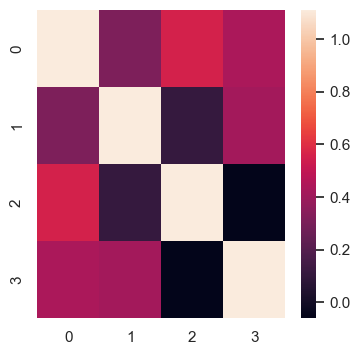

In [418]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
sns.heatmap(C)

Because the matrix is square and symmetrical, me can perform an operation of the decomposition for this matrix. $$C = VLV^T$$

V is a matrix of eigenvectors (hence we usually annotate it with V) - each column in this matrix is an eigenvector. L is a diagonal matrix of eigenvalues (typically we annotate eigenvalues with $\lambda$, hence the matrix is annotated as L). We will perform this decomposition using a [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class from sklearn.

In [419]:
from sklearn.decomposition import PCA
#here we initialize the PCA
pca = PCA()
#here we convert the data using PCA
X_pca = pca.fit_transform(X)

After applying PCA to the data, we can select the V matrix using the following code:

In [420]:
#eigenvectors are columns of the V matrix, hence the transposition
V = pca.components_.T
V

array([[-0.62289328, -0.24467571, -0.3129465 ,  0.67394528],
       [-0.47240854,  0.38128489,  0.79160462,  0.06938387],
       [-0.3977625 , -0.71406394,  0.15519136, -0.55480927],
       [-0.4802282 ,  0.53373057, -0.50134045, -0.48287711]])

We can get the vector of eigenvalues with:

In [421]:
pca.explained_variance_

array([2.04098736, 1.28564188, 0.74512873, 0.37268648])

Note that the eigenvalues are not in a random order. They are in fact sorted in a descending order. Let's create a diagonal matrix using the eigenvalues.

In [422]:
L = np.diag(pca.explained_variance_)
L

array([[2.04098736, 0.        , 0.        , 0.        ],
       [0.        , 1.28564188, 0.        , 0.        ],
       [0.        , 0.        , 0.74512873, 0.        ],
       [0.        , 0.        , 0.        , 0.37268648]])

Let's now check if the decomposition worked.

In [423]:
pca.get_covariance()

array([[ 1.11111111,  0.31347866,  0.55476214,  0.43825019],
       [ 0.31347866,  1.11111111,  0.11067615,  0.41645807],
       [ 0.55476214,  0.11067615,  1.11111111, -0.05824746],
       [ 0.43825019,  0.41645807, -0.05824746,  1.11111111]])

In [424]:
np.dot(np.dot(V,L),V.T) 

array([[ 1.11111111,  0.31347866,  0.55476214,  0.43825019],
       [ 0.31347866,  1.11111111,  0.11067615,  0.41645807],
       [ 0.55476214,  0.11067615,  1.11111111, -0.05824746],
       [ 0.43825019,  0.41645807, -0.05824746,  1.11111111]])

In [425]:
C

array([[ 1.11111111,  0.31347866,  0.55476214,  0.43825019],
       [ 0.31347866,  1.11111111,  0.11067615,  0.41645807],
       [ 0.55476214,  0.11067615,  1.11111111, -0.05824746],
       [ 0.43825019,  0.41645807, -0.05824746,  1.11111111]])

 ### Excercise.

Repeat the code execution, but this time omit the standarization. Check whether the method worked as intended.

 ----------

OK, we know how to decompose the covariance matrix of the data into three matrices. Let's try to interpret those matrices.

In [426]:
V

array([[-0.62289328, -0.24467571, -0.3129465 ,  0.67394528],
       [-0.47240854,  0.38128489,  0.79160462,  0.06938387],
       [-0.3977625 , -0.71406394,  0.15519136, -0.55480927],
       [-0.4802282 ,  0.53373057, -0.50134045, -0.48287711]])

In [427]:
L

array([[2.04098736, 0.        , 0.        , 0.        ],
       [0.        , 1.28564188, 0.        , 0.        ],
       [0.        , 0.        , 0.74512873, 0.        ],
       [0.        , 0.        , 0.        , 0.37268648]])

Note that the entire first column of $VL$ is basically the first column of $V$ scaled by the first eigenvalue.

In [428]:
tmp = V[0,0] * L[0,0]
print(tmp)
tmp = V[1,0] * L[0,0]
print(tmp)
tmp = V[2,0] * L[0,0]
print(tmp)
tmp = V[3,0] * L[0,0]
print(tmp)

-1.271317315942081
-0.9641798655362285
-0.8118282242358367
-0.9801396785877292


In [429]:
VL = np.dot(V,L)
VL

array([[-1.27131732, -0.31456534, -0.23318543,  0.25117029],
       [-0.96417987,  0.49019582,  0.58984735,  0.02585843],
       [-0.81182822, -0.9180305 ,  0.11563754, -0.20676991],
       [-0.98013968,  0.68618638, -0.37356318, -0.17996177]])

The same is true for every next column and the further eigenvalues. A very similar mechanism works for $LV^T$.

In [430]:
tmp = V.T[0,0] * L[0,0]
print(tmp)
tmp = V.T[0,1] * L[0,0]
print(tmp)
tmp = V.T[0,2] * L[0,0]
print(tmp)
tmp = V.T[0,3] * L[0,0]
print(tmp)

-1.271317315942081
-0.9641798655362285
-0.8118282242358367
-0.9801396785877292


In [431]:
np.dot(L,V.T)

array([[-1.27131732, -0.96417987, -0.81182822, -0.98013968],
       [-0.31456534,  0.49019582, -0.9180305 ,  0.68618638],
       [-0.23318543,  0.58984735,  0.11563754, -0.37356318],
       [ 0.25117029,  0.02585843, -0.20676991, -0.17996177]])

Now, since $(VL)V^T = V(LV^T)$

In [432]:
np.dot(np.dot(V,L),V.T) 

array([[ 1.11111111,  0.31347866,  0.55476214,  0.43825019],
       [ 0.31347866,  1.11111111,  0.11067615,  0.41645807],
       [ 0.55476214,  0.11067615,  1.11111111, -0.05824746],
       [ 0.43825019,  0.41645807, -0.05824746,  1.11111111]])

In [433]:
np.dot(V,np.dot(L,V.T)) 

array([[ 1.11111111,  0.31347866,  0.55476214,  0.43825019],
       [ 0.31347866,  1.11111111,  0.11067615,  0.41645807],
       [ 0.55476214,  0.11067615,  1.11111111, -0.05824746],
       [ 0.43825019,  0.41645807, -0.05824746,  1.11111111]])

We can clearly see that the $L$ matrix represents the impact of each row and column of the $V$ matrix on the decomposition. If the lowest eigenvalues were really small we could completely omit them and get a good representation of the original data using this method. That's exactly how it works, the $V$ matrix is a matrix of what we call 'principal directions' or 'principal axes', and the $L$ matrix is a matrix of what we call 'principal components', which represent the impact, the 'PC score', of each of the directions on the data. The principal directions explain the variance in the data, the principal components tell us how much of the variance is explained by this component. The PCA method works simply like this:
  - decompose the data
  - remove the eigenvectors and eigenvalues, which are not the 'top n' (the vectors and values are sorted, we just remove the rows and columns from the matrices beyond the n, by simply setting the nth eigenvalue  to 0, or cutting the vectors and rows beyond the nth one)
  - recreate the data using the changed matrix of principal components (with the eigenvalues beyond the nth one set to 0)

Let's check how it works in practice.

In [434]:
pca = PCA(n_components = 2)

Iris_new = pd.DataFrame(pca.fit_transform(Iris_df), columns = ['PC1','PC2'])
Iris_new


,PC1,PC2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


Let's look at the reduced dataset and the new features (components).

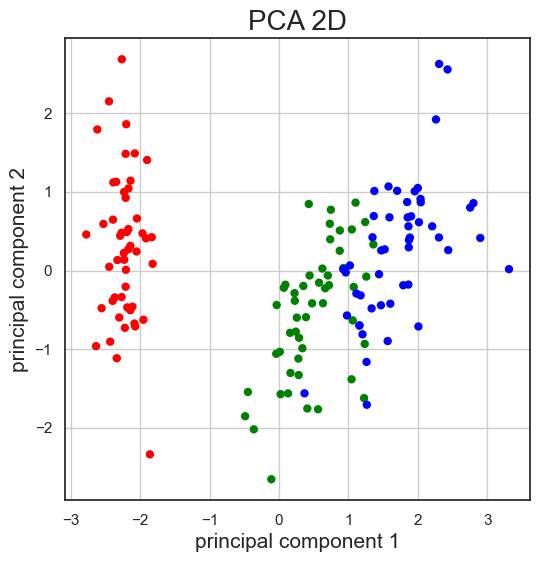

In [435]:
colrs = np.array(['red', 'green', 'blue'])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('PCA 2D', fontsize=20)
ax.set_xlabel('principal component 1', fontsize=15)
ax.set_ylabel('principal component 2', fontsize=15)
ax.grid()

ax.scatter(Iris_new.PC1, Iris_new.PC2, c=colrs[y], s=25)

We can see the impact of each of the components on the data. Here we can see that the 1st component is much more important than the second one.

In [436]:
for i,v in enumerate(pca.explained_variance_ratio_):
    print(f'Variance explained by component {i+1}: {v:.4f}')

Variance explained by component 1: 0.7296
Variance explained by component 2: 0.2285


In [437]:
Iris_df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [438]:
print(pca.components_)

[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]


This means that the `PC1` is defined as:

`pca_1 = 0.52 * 'sepal length (cm)' - 0.26 * 'sepal width (cm)' + 0.58 * 'petal length (cm)' + 0.56 * 'petal width (cm)'`

In [439]:
test = Iris_df['sepal length (cm)'] * pca.components_[0,0] + Iris_df['sepal width (cm)'] * pca.components_[0,1] + Iris_df['petal length (cm)'] * pca.components_[0,2] + Iris_df['petal width (cm)'] * pca.components_[0,3]
#test
for i in range(4):
  print(np.round(list(test)[i] - list(Iris_new.PC1)[i],2))

-0.0
-0.0
-0.0
-0.0


Since the first component explains so much variance in the dataset, maybe we can compress the data even further?

In [440]:
pca = PCA(n_components=1)

X_pca = pca.fit(Iris_df).transform(Iris_df)
X_pca[:5], y[:5]

(array([[-2.26470281],
        [-2.08096115],
        [-2.36422905],
        [-2.29938422],
        [-2.38984217]]),
 array([0, 0, 0, 0, 0]))

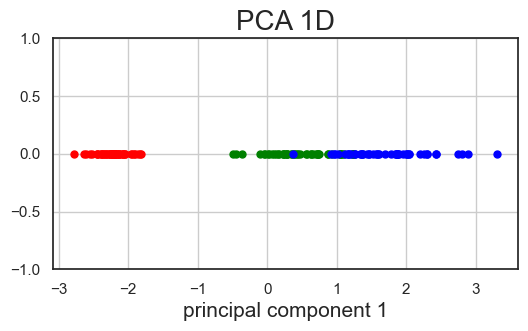

In [441]:
colrs = np.array(['red', 'green', 'blue'])

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('PCA 1D', fontsize=20)
ax.set_xlabel('principal component 1', fontsize=15)
ax.set_ylim(-1., 1.)
ax.grid()

for c in np.unique(y):
    idx = y == c
    vals = X_pca[idx, 0]
    ax.scatter(vals, np.zeros_like(vals) + np.random.uniform(-0.001,
                                                             0.001, len(vals)), s=25, color=colrs[c])

## Uniform Manifold Approximation and Projection (UMAP)

UMAP is one of the most interesting recent developments in the space of dimensionality reduction/feature extraction algorithms. Understanding its mechanics requires a bit of math, interested students can check the document ["How UMAP works"](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) or delve directly into the [original paper](https://arxiv.org/abs/1802.03426). For us it will be a cool and simple method of projecting high dimensional data onto lower dimensions.

To instlal `umap` please use the following command:

In [442]:
!pip install umap-learn

In [443]:
!pip install numba 

In [444]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pandas as pd

In [445]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [446]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['class'] = data['target']

In [447]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


/Users/luncenok/Studia/sem4/DM/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luncenok/Studia/sem4/DM/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/luncenok/Studia/sem4/DM/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luncenok/Studia/sem4/DM/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:

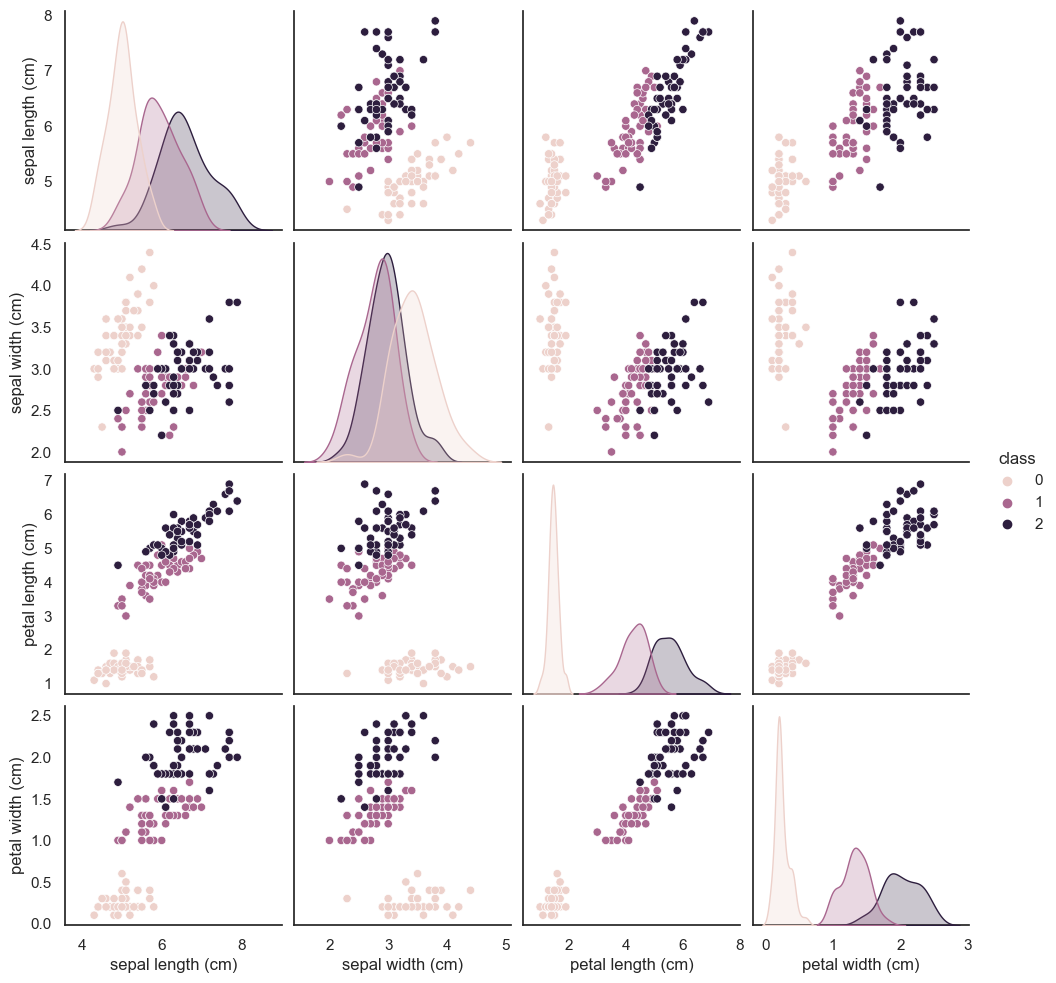

In [448]:
sns.pairplot(df, hue='class')

In [449]:
from sklearn.preprocessing import StandardScaler

X = data['data']
y = data['target']

X_scaled = StandardScaler().fit_transform(X)

In [450]:
import umap

umap_transformer = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.2
)

X_umap = umap_transformer.fit_transform(X_scaled)

Text(0.5, 1.0, 'UMAP projection of Iris dataset')

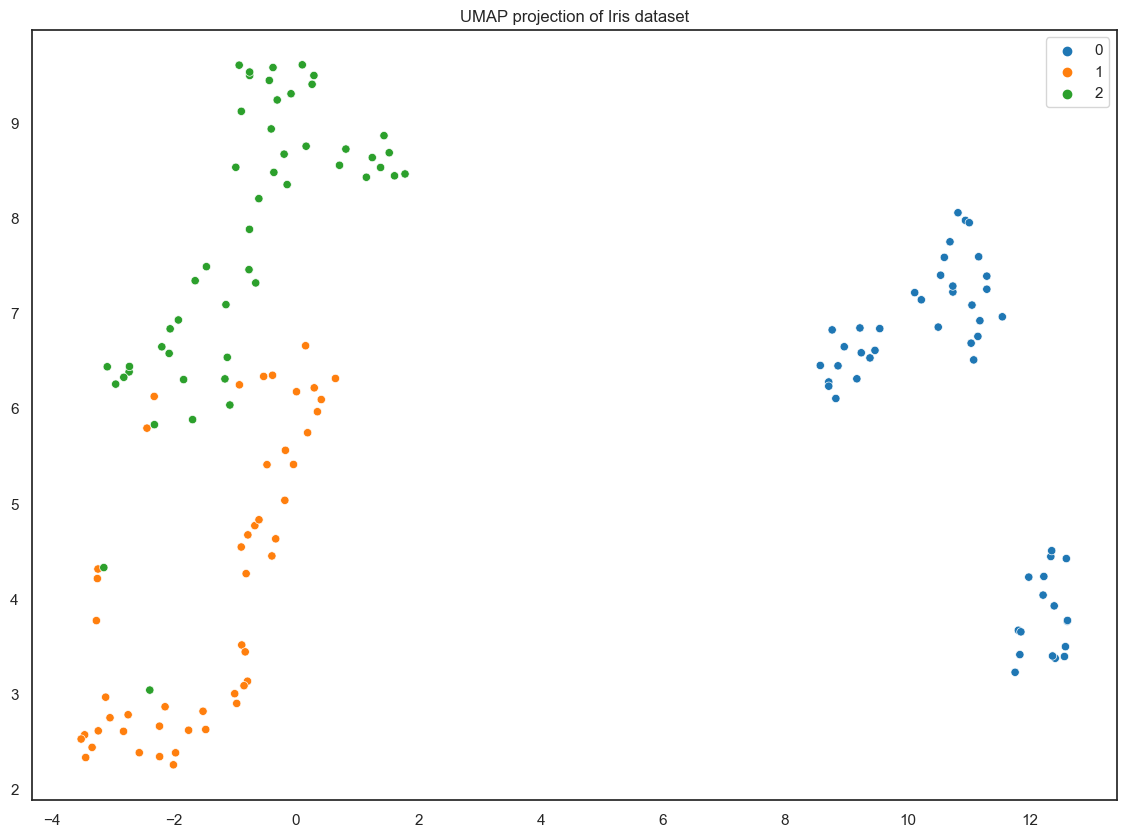

In [454]:
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='tab10').set_title('UMAP projection of Iris dataset')

# LDA
Contrary to PCA, Linear Discriminant Analysis is a supervised method of extracting the new features. In the examples in this notebook, and in the previous excercise, we can notice, that the ability to separate calsses within the data is a good quality of a dataset. The LDA formalizes that quality as separability. We will not go into the details, but the separability is given by between-class varaince. Basically the more different samples for separate classes are, the higher the value of separability:

 $$Sep_{ds} = \sum_{c\in classes} (\overline{x_c} - \overline{x}) \cdot (\overline{x_c} - \overline{x})^T $$

On the other hand, the samples within the same class should be similar to each other. The variance within the class should be as low as possible.

 $$Sim_{ds} = \sum_{c\in classes}\sum_{x_{i,j} \in x_c} (x_{i,j} - \overline{x_c}) \cdot (x_{i,j} - \overline{x_c})^T $$

 Our goal is to maximize the 1st goal (Sep) and minimize the second one (Sim).

  In principle the code for LDA is very similar to the code for PCA.

In [452]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 2)

Iris_lda = pd.DataFrame(lda.fit_transform(Iris_df, y), columns = ['LC1','LC2'])
Iris_lda

,LC1,LC2
0,8.061800,-0.300421
1,7.128688,0.786660
2,7.489828,0.265384
3,6.813201,0.670631
4,8.132309,-0.514463
...,...,...
145,-5.645003,-1.677717
146,-5.179565,0.363475
147,-4.967741,-0.821141
148,-5.886145,-2.345091


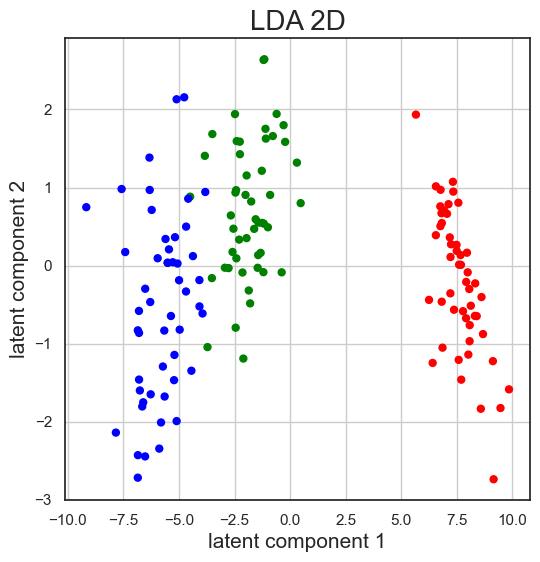

In [453]:
colrs = np.array(['red', 'green', 'blue'])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('LDA 2D', fontsize=20)
ax.set_xlabel('latent component 1', fontsize=15)
ax.set_ylabel('latent component 2', fontsize=15)
ax.grid()

ax.scatter(Iris_lda.LC1, Iris_lda.LC2, c=colrs[y], s=25)

You should be able to notice that LDA gives us an output that is easier to separate than the result given by PCA.

 # Exercise / Homework

 1. Import the wine dataset and transform it into a pandas dataframe. Use the methods described in this notebook to represent the classes for the dataset on a 2-D diagram.

In [455]:
from sklearn.datasets import load_wine

data = load_wine()

X = data['data']
y = data['target']

X_scaled = StandardScaler().fit_transform(X)

Wine_df = pd.DataFrame(X_scaled, y, columns = data.feature_names)
Wine_df.describe().round(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.43,-1.43,-3.68,-2.67,-2.09,-2.11,-1.70,-1.87,-2.07,-1.63,-2.09,-1.90,-1.49
25%,-0.79,-0.66,-0.57,-0.69,-0.82,-0.89,-0.83,-0.74,-0.60,-0.80,-0.77,-0.95,-0.78
50%,0.06,-0.42,-0.02,0.00,-0.12,0.10,0.11,-0.18,-0.06,-0.16,0.03,0.24,-0.23
75%,0.84,0.67,0.70,0.60,0.51,0.81,0.85,0.61,0.63,0.49,0.71,0.79,0.76
max,2.26,3.11,3.16,3.15,4.37,2.54,3.06,2.40,3.49,3.44,3.30,1.96,2.97


In [456]:
pca = PCA(n_components = 2)

Wine_new = pd.DataFrame(pca.fit_transform(Wine_df), columns = ['PC1','PC2'])
Wine_new

,PC1,PC2
0,3.316751,-1.443463
1,2.209465,0.333393
2,2.516740,-1.031151
3,3.757066,-2.756372
4,1.008908,-0.869831
...,...,...
173,-3.370524,-2.216289
174,-2.601956,-1.757229
175,-2.677839,-2.760899
176,-2.387017,-2.297347


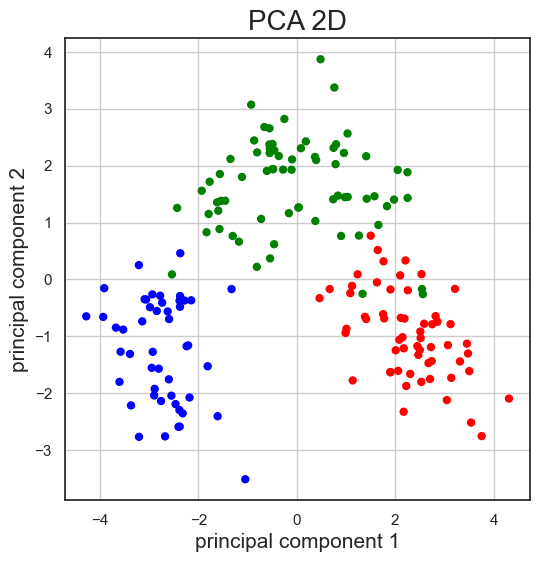

In [457]:
colors = np.array(['red', 'green', 'blue'])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('PCA 2D', fontsize=20)
ax.set_xlabel('principal component 1', fontsize=15)
ax.set_ylabel('principal component 2', fontsize=15)
ax.grid()

ax.scatter(Wine_new.PC1, Wine_new.PC2, c=colrs[y], s=25)